#BRCA2 homozygous cell line specific mutations

---
###Basic idea:  Calculate BRCA2 homozygous, and all other mean reference frequencies

- Cell line specific heterozygous mutations have around 50% reference base count in samples in the cell line, and around 100% in other samples. So the average reference base frequency among the cell line samples is around 50%, and around 100% among other samples. But because of the large number of reads in all samples, the distribution are more localized.



- To see these mutations I will plot almost all positions on an (average other samples refbase freq, average cell line refbase freq ) plane. Cell line specific mutations are expected to be in the middle right (1,0.5), and are expected to be clearly separated from other positions.


- These mutations are identified through a very simple and robust method, so they are good candidates for testing the sensitivity of mutation calling methods.

----

<span class ='label label-warning'>NOTE</span> Code is hiden in this notebook please click below, to see it

In [7]:
#Toggle code

from IPython.display  import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [ ]:
%%writefile brca2_vs_all.py
#!/usr/bin/python

#First script:
    # Input is a filtered pileup-like format
    # there are lines in Orsi's format, and i dont use them
    # writefile magic writes these files
    # they will be later executed by slurm

#import modules
import subprocess
import sys
import re
import numpy as np
import fnmatch
import os

#input ouput files
input_dir='/nagyvinyok/adat83/sotejedlik/orsi/SNV/SNV_list_withB_allsamples/'
output_dir='/nagyvinyok/adat83/sotejedlik/ribli/dt40/snp/BRCA2_vs_all/'
#subprocess.call(['mkdir',output_dir])
output_dir='/nagyvinyok/adat83/sotejedlik/ribli/dt40/snp/BRCA2_vs_all/heatmap/'
#subprocess.call(['mkdir',output_dir])

#which file to run on come in cmdline arg
input_fname=sys.argv[1]

#filenames for samplenames
rm_dup_dir='/nagyvinyok/adat83/sotejedlik/orsi/bam_all_links/'
#collect filenames
fnames=[]
for fname in os.listdir(rm_dup_dir):
    if (fnmatch.fnmatch(fname, '*.bam') and 
        not fnmatch.fnmatch(fname,"*.bai")):
        fnames.append(fname)
fnames=sorted(fnames)

#select the group samples set
group=[]
for i in range(108,118): 
    group.append('DS'+str(i)+'_RMdup_picard_realign.bam')
                 
#create array to index into numpy arrays
group_bool,else_bool,group=[],[],set(group)
for sample in fnames:
    group_bool.append(sample in group)
    else_bool.append(not (sample in group))
group_bool,else_bool=np.array(group_bool),np.array(else_bool)

#matrix for heatmap
resolution=200 #resolution hard coded !!!!!!!!
heat_mat=np.zeros((resolution+1,resolution+1),dtype=np.int32)

#run the pipeline  
f_in=open(input_dir+input_fname)
for line in f_in: 
    #line in Orsis format
    if line[0]=='#':
        continue
              
    #parse line
    linelist=line.strip().upper().split(' ')
    covs=np.array(map(int,linelist[3::2]),dtype=np.int32)
    #cov=0 make freqs meaningless
    if (linelist[3::2].count('0')!=0):
        continue
    bases=linelist[4::2]
    ref_count=[]
    for i in xrange(len(bases)):
        ref_count.append(len(re.findall('[\.\,]',bases[i])))

    if (len(ref_count)!=len(covs)):
        print line
        break

    ref_freq=np.array(ref_count,dtype=np.double)/covs
    #calculate group freqs and save in matrix
    group_freq=np.mean(ref_freq[group_bool])
    else_freq=np.mean(ref_freq[else_bool])
    heat_mat[int(resolution*group_freq),int(resolution*else_freq)]+=1

#close file
f_in.close()
#save it
np.savetxt(output_dir + input_fname.split('.')[0]+'.mat',heat_mat,fmt='%d')

In [ ]:
#Run them in slurm

import os
import subprocess
input_dir='/nagyvinyok/adat83/sotejedlik/orsi/SNV/SNV_list_withB_allsamples/'
for filename in os.listdir(input_dir):
    try:
        print subprocess.check_output([ 'sbatch', #'-C','jimgray85',
                                       '--mem',str(1000),'./brca2_vs_all.py' ,
                                       filename],stderr=subprocess.STDOUT),
    except subprocess.CalledProcessError, e:
        print e.output,

###Plot the 'heatmap'
- its half heatmap, half scatter because of the high resolution

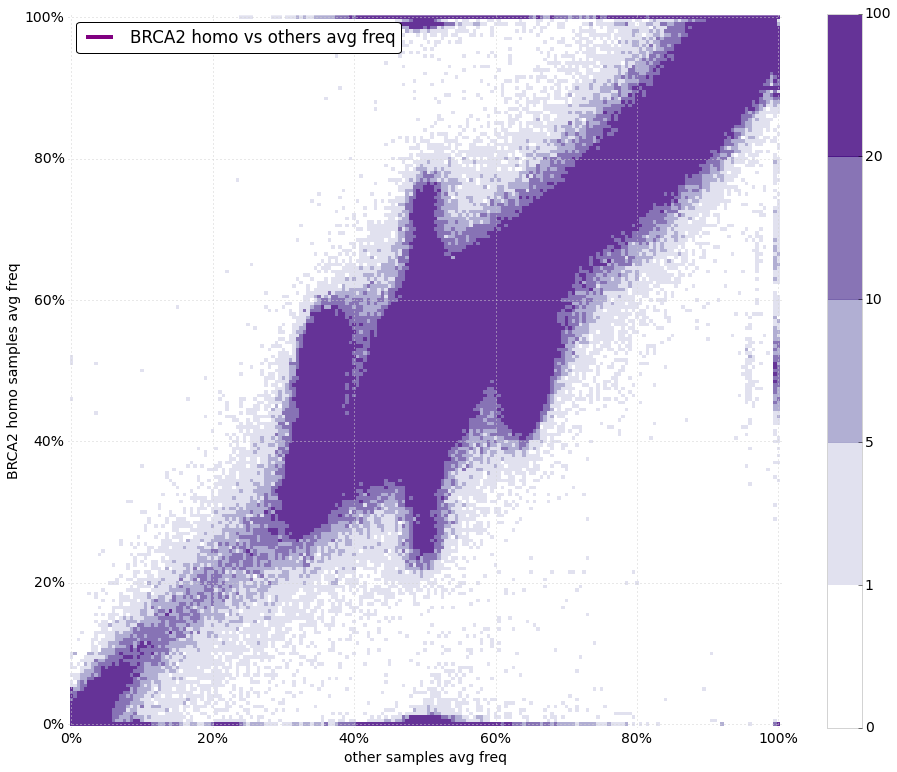

In [3]:
import os
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib as mpl
import pandas as pd #instead of numpy for much faster csv loading
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

inputdir='/nagyvinyok/adat83/sotejedlik/ribli/dt40/snp/BRCA2_vs_all/heatmap/'

#load result matrices
m=pd.read_csv(inputdir+os.listdir(inputdir)[0],sep=' ',header=None)
for filename in os.listdir(inputdir):
    try:
        m+=pd.read_csv(inputdir+filename,sep=' ',header=None)
    except:
        pass

#plot
fig,ax=plt.subplots()
fig.set_size_inches(16,16)

# define the colormap
cmap = plt.cm.Purples
# extract all colors from the map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be white
cmaplist[0] = (1.0,1.0,1.0,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = [0,1,5,10,20,100]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

#show the image
cax = ax.imshow(m,interpolation='none',norm=norm,cmap=cmap,alpha=0.8,origin='lower')

cbar=fig.colorbar(cax,shrink=0.8)
cbar.outline.set_edgecolor('lightgrey')

#set grid
ax.grid(True,c='lightgrey',lw=1,linestyle='dotted')
ax.set_frame_on(False)
tics=ax.xaxis.set_ticks(np.linspace(0,200,6))
labs=ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'], rotation='horizontal')
tics=ax.yaxis.set_ticks(np.linspace(0,200,6))
labs=ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'], rotation='horizontal')

ax.set_xlim(-1,201)
ax.set_ylim(-1,201)

#enlarge font
mpl.rcParams['font.size']=14.0

# remove tick marks
ax.xaxis.set_tick_params(size=0)
ax.yaxis.set_tick_params(size=0)

#legend
ax.plot([],[],c='purple',lw=4,label='BRCA2 homo vs others avg freq')
ax.legend(fancybox=True,loc='upper left')

#annotate
ax.set_title('')
ax.set_xlabel('other samples avg freq')
cax=ax.set_ylabel('BRCA2 homo samples avg freq')

---
###Zoom on the interesting region

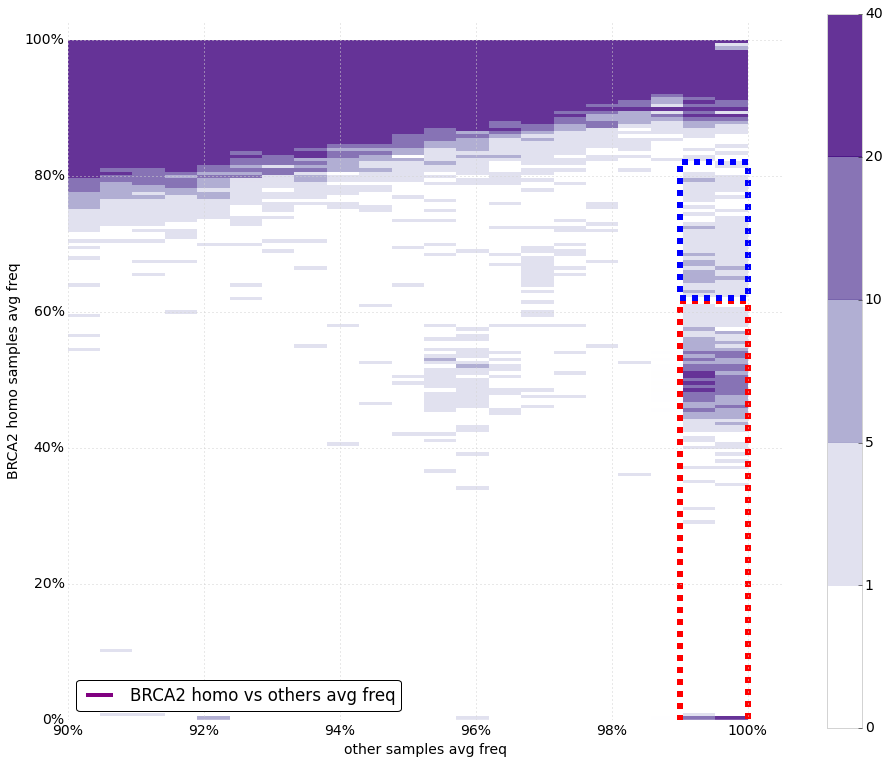

In [4]:
# define the bins and normalize
bounds = [0,1,5,10,20,40]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

#plot
fig,ax=plt.subplots()
cax = ax.imshow(np.array(m)[:,180:],interpolation='none',extent=[180,200,0,200],
                aspect=0.1,alpha=0.8,origin='lower',cmap=cmap,norm=norm)

cbar=fig.colorbar(cax,shrink=0.8)
cbar.outline.set_edgecolor('lightgrey')

#legend
ax.plot([],[],c='purple',lw=4,label='BRCA2 homo vs others avg freq')
ax.legend(fancybox=True,loc='lower left')

#annotate
ax.set_title('')
ax.set_xlabel('other samples avg freq')
ax.set_ylabel('BRCA2 homo samples avg freq')
fig.set_size_inches(16,16)

#set w grd
ax.grid(True,c='lightgrey',lw=1,linestyle='dotted')
ax.set_frame_on(False)
tics=ax.xaxis.set_ticks(np.linspace(180,200,6))
tics=ax.yaxis.set_ticks(np.linspace(0,200,6))

ax.set_xlim(180,201)
ax.set_ylim(0,205)

labs=ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'], rotation='horizontal')
labs=ax.set_xticklabels(['90%','92%','94%','96%','98%','100%'], rotation='horizontal')

# remove tick marks
ax.xaxis.set_tick_params(size=0)
ax.yaxis.set_tick_params(size=0)

#50% ones
rect=plt.Rectangle((198,-1),2,124, fc='none',ec='r',lw=6, linestyle='dashed')
cax=ax.add_patch(rect)

#lower freq ones
rect=plt.Rectangle((198,124),2,40, fc='none',ec='b',lw=6,linestyle='dashed')
cax=ax.add_patch(rect)

---
#Conclusions:

- <span class ='label label-success'>NOTE</span> There is a nice 1,0.5 cluster


- <span class ='label label-warning'>NOTE</span> altough there is an other cluster not very clearly separated from  this, at 1,0,7. This spot might be mostly due to more than diploid regions. 


- <span class ='label label-warning'>NOTE</span> there is another cluster at 96% other freq. This is possibly the mutations shared between db1, and brca2 homo (according the [sample tree](http://dkrib.web.elte.hu/dt40/phylogeny/phylogeny.html))


---
##Collect the line specific mutations to files

In [ ]:
%%writefile brca2_vs_all_collect_mut.py
#!/usr/bin/python

#import modules
import subprocess
import sys
import re
import numpy as np
import fnmatch
import os

#input ouput files
input_dir='/nagyvinyok/adat83/sotejedlik/orsi/SNV/SNV_list_withB_allsamples/'
output_dir='/nagyvinyok/adat83/sotejedlik/ribli/dt40/snp/BRCA2_vs_all'
subprocess.call(['mkdir',output_dir+'/het_snp'])
subprocess.call(['mkdir',output_dir+'/lowfreq_snp'])

#which file to run on come in cmdline arg
input_fname=sys.argv[1]

#filenames for samplenames
rm_dup_dir='/nagyvinyok/adat83/sotejedlik/orsi/bam_all_links/'
#collect filenames
fnames=[]
for fname in os.listdir(rm_dup_dir):
    if (fnmatch.fnmatch(fname, '*.bam') and 
        not fnmatch.fnmatch(fname,"*.bai")): #strange .bai convention!!!
        fnames.append(fname)
fnames=sorted(fnames)

#select the group samples set
group=[]
for i in range(108,118): 
    group.append('DS'+str(i)+'_RMdup_picard_realign.bam')

#create array to index into numpy arrays
group_bool,else_bool,group=[],[],set(group)
for sample in fnames:
    group_bool.append(sample in group)
    else_bool.append(not (sample in group))
group_bool,else_bool=np.array(group_bool),np.array(else_bool)

#output files
f_het=open(output_dir+'/het_snp/'+input_fname,'w')
f_lowfreq=open(output_dir+'/lowfreq_snp/'+input_fname,'w')

#run the pipeline  
f_in=open(input_dir+input_fname)
for line in f_in: 
    
    #line in Orsis format
    if line[0]=='#':
        continue
        
    #parse line
    linelist=line.strip().upper().split(' ')
    covs=np.array(map(int,linelist[3::2]),dtype=np.int32)

    #cov=0 make freqs meaningless
    if (linelist[3::2].count('0')!=0):
        continue

    bases=linelist[4::2]
    ref_count=[]
    for i in xrange(len(bases)):
        ref_count.append(len(re.findall('[\.\,]',bases[i]))) 
    ref_freq=np.array(ref_count,dtype=np.double)/covs

    #calculate group freqs
    group_freq=np.mean(ref_freq[group_bool])
    else_freq=np.mean(ref_freq[else_bool])

    #save the line specific mutations
    if( group_freq <= 0.62  and else_freq >=0.99):
        f_het.write(line)
    if(group_freq >= 0.63 and group_freq <= 0.82  and 
      else_freq >= 0.99):
        f_lowfreq.write(line)

#close files
f_in.close()
f_het.close()
f_lowfreq.close()

In [ ]:
#Run them in slurm

import os
import subprocess
input_dir='/nagyvinyok/adat83/sotejedlik/orsi/SNV/SNV_list_withB_allsamples/'
for filename in os.listdir(input_dir):
    try:
        print subprocess.check_output([ 'sbatch','-C','jimgray83',
                                       '--mem',str(300),'./brca2_vs_all_collect_mut.py' ,
                                       filename],stderr=subprocess.STDOUT),
    except subprocess.CalledProcessError, e:
        print e.output,

How many SNPs are there?

In [10]:
%%bash
dir='/nagyvinyok/adat83/sotejedlik/ribli/dt40/snp/BRCA2_vs_all'

rm $dir/het_snp/all.pup
cat $dir/het_snp/* > $dir/het_snp/all.pup 

echo The number of het SNPs:
cat $dir/het_snp/all.pup | wc -l
echo


rm $dir/lowfreq_snp/all.pup
cat $dir/lowfreq_snp/* > $dir/lowfreq_snp/all.pup 

echo The number of low frequency SNPs:
cat $dir/lowfreq_snp/all.pup | wc -l

The number of het SNPs:
673

The number of low frequency SNPs:
193
